# Extreme Learning Machine

Sample implementation of ELM that will classify MNIST dataset. Please visit [blog post]() for more theoretical background.

In [1]:
import numpy as np

I am adding a `strict` parameter due to, probably mine, misunderstanding of the [paper](http://axon.cs.byu.edu/~martinez/classes/678/Presentations/Yao.pdf) on which I've based this notebook.

In equation _4_ we can clearly see that each row has the same set of random weights and biases. This, unfortunately, leads to very poor performance.

In [2]:
def generate_hidden_values(X_input, hidden_nodes, strict=False):
    _, single_input_length = X_input.shape
    random_hidden_bias = np.random.normal(size=(1, hidden_nodes))
    if strict:
        random_hidden_node_values = np.tile(np.random.normal(size=(1, hidden_nodes)), (single_input_length, 1))
    else:
        random_hidden_node_values = np.random.normal(size=(single_input_length, hidden_nodes))
    return (random_hidden_node_values, random_hidden_bias)

In [3]:
def calculate_hidden_layer(X_input, hidden_node_values, hidden_bias, activation_func):
    X_length, _ = X_input.shape
    return activation_func(np.dot(X_input, hidden_node_values) + np.tile(hidden_bias, (X_length, 1)))

In [4]:
def solve_with_least_squares(hidden_layer, y_labels):
    return np.dot(np.linalg.pinv(hidden_layer), y_labels)

In [5]:
# Overkill, but as lazy as possible way to get mnist data.
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [6]:
def flatten_image(images):
    n, x, y = images.shape
    return images.reshape((n, x * y))

def one_hot_encode(labels, classes=10):
    y_encoded = np.zeros([labels.shape[0], classes])
    for i in range(labels.shape[0]):
        y_encoded[i][labels[i]] = 1
    return y_encoded

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [7]:
flatten_image(x_train).shape
print(one_hot_encode(y_train))

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [17]:
# Training
import time
def train(hidden_nodes):
    start = time.perf_counter()
    flat_x_train = flatten_image(x_train)
    encoded_y_train = one_hot_encode(y_train)
    random_hidden_node_values, random_hidden_bias = generate_hidden_values(flat_x_train, hidden_nodes, False)
    hidden_layer_training = calculate_hidden_layer(flat_x_train, random_hidden_node_values, random_hidden_bias, sigmoid)
    beta_layer = solve_with_least_squares(hidden_layer_training, encoded_y_train)
    end = time.perf_counter()
    return random_hidden_node_values, random_hidden_bias, beta_layer, end - start

In [18]:
# Testing
def test(random_hidden_node_values, random_hidden_bias, beta_layer):
    flat_x_test = flatten_image(x_test)
    encoded_y_test = one_hot_encode(y_test)
    hidden_layer_test = calculate_hidden_layer(flat_x_test, random_hidden_node_values, random_hidden_bias, sigmoid)
    predictions = np.dot(hidden_layer_test, beta_layer)

    correct = 0
    total = y_test.shape[0]
    for i in range(total):
        predicted = np.argmax(predictions[i])
        test = np.argmax(encoded_y_test[i])
        correct = correct + (1 if predicted == test else 0)
        accuracy = correct/total
    return accuracy
    

In [38]:
results = []
np.random.seed(28)
# Just for warm up
random_hidden_node_values, random_hidden_bias, beta_layer, training_time = train(100)
for hdn_nds in [1, 2, 5, 10, 20, 25, 50, 100, 150, 200, 250, 350, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]:
    random_hidden_node_values, random_hidden_bias, beta_layer, training_time = train(hdn_nds)
    acc = test(random_hidden_node_values, random_hidden_bias, beta_layer)
    results.append((hdn_nds, acc, training_time))
results

[(1, 0.1244, 0.23633954899923992),
 (2, 0.1616, 0.2342293609999615),
 (5, 0.2733, 0.24992246500005422),
 (10, 0.3435, 0.26424924899947655),
 (20, 0.4407, 0.303723226999864),
 (25, 0.5486, 0.3341872290002357),
 (50, 0.6473, 0.46245579200058273),
 (100, 0.7639, 0.7946228649998375),
 (150, 0.8143, 1.1609560950000741),
 (200, 0.837, 1.5828469230000337),
 (250, 0.8545, 1.9802944539997043),
 (350, 0.8705, 4.698232652000115),
 (500, 0.8881, 4.662012087999756),
 (1000, 0.92, 12.094407403999867),
 (1500, 0.9327, 21.474655124000492),
 (2000, 0.9385, 27.761893640999915),
 (2500, 0.9438, 40.68164735299979),
 (3000, 0.9489, 58.47160399000131),
 (4000, 0.9561, 103.10882506099915),
 (5000, 0.9582, 173.00890614000127)]

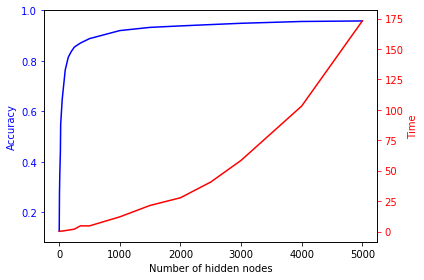

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
t = [node for (node, acc, time) in results]
s1 = [acc for (node, acc, time) in results]
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('Number of hidden nodes')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = [time for (node, acc, time) in results]
ax2.plot(t, s2, 'r-')
ax2.set_ylabel('Time', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()